# Project 4 - 네이버 영화리뷰 감성 분석하기

In [16]:
import gensim
import os

from konlpy.tag import Mecab
from collections import Counter

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### (1) 데이터 준비 및 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt') # 150000 데이터
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt') # 50000 데이터

train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


### (2) 데이터로더 구성

In [21]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words = 10000

encode, decode 함수를 구현한다.

In [4]:
# 영단어로 이루어진 벡터 -> 숫자 벡터로 encode
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_word_vec(word_vec, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in word_vec]

# 여러 문장 한꺼번에 encode
def get_encoded_word_vecs(word_vecs, word_to_index):
    return [get_encoded_word_vec(word_vec, word_to_index) for word_vec in word_vecs]

# 숫자로 encode된 벡터 -> 영단어 벡터로 decode
# 단, [1:]를 통해 <BOS>를 제외
def get_decoded_word_vec(enc_word_vec, index_to_word):
    return [index_to_word[index] if index in index_to_word else '<UNK>' for index in enc_word_vec[1:]]

# 여러 문장 한꺼번에 decode
def get_decoded_word_vecs(enc_word_vecs, index_to_word):
    return [get_decoded_word_vec(enc_word_vec, index_to_word) for enc_word_vec in enc_word_vecs]

data load 함수를 구현한다.

In [5]:
def load_data(train_data, test_data, num_words=10000):
    # 데이터 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        # 문장을 형태소로 분리하고 stopwords에 없는 단어들만 추가
        token_X = tokenizer.morphs(sentence)
        X_train.append([word for word in token_X if not word in stopwords])

    X_test = []
    for sentence in test_data['document']:
        # 문장을 형태소로 분리하고 stopwords에 없는 단어들만 추가
        token_X = tokenizer.morphs(sentence)
        X_test.append([word for word in token_X if not word in stopwords])
    
    # 가장 빈도수가 높은 10000개 단어 선택
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words - 4)

    # 단어 사전 구성
    vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
    index_to_word = {index : word for index, word in enumerate(vocab)}
    word_to_index = {word : index for index, word in enumerate(vocab)}

    X_train = get_encoded_word_vecs(X_train, word_to_index)
    X_test = get_encoded_word_vecs(X_test, word_to_index)
    y_train = list(train_data['label'])
    y_test = list(test_data['label'])
    
    return X_train, y_train, X_test, y_test, index_to_word, word_to_index

In [22]:
X_train, y_train, X_test, y_test, index_to_word, word_to_index = load_data(train_data, test_data, num_words)

### (3) 모델 구성을 위한 데이터 분석 및 가공

In [23]:
# 텍스트데이터 문장길이 리스트 생성
num_tokens = [len(tokens) for tokens in (X_train + X_test)]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차
print('문장길이 평균 :', np.mean(num_tokens))
print('문장길이 최대 :', np.max(num_tokens))
print('문장길이 표준편차 :', np.std(num_tokens))

# 최대 길이는 (평균 + 2*표준편차)로 설정
maxlen = int(np.mean(num_tokens) + 2 * np.std(num_tokens))
print('maxlen :', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < maxlen) / len(num_tokens) * 100 : .1f}%가 maxlen 설정값 이내에 포함')

문장길이 평균 : 16.96940191154864
문장길이 최대 : 117
문장길이 표준편차 : 12.843571191092
maxlen : 42
전체 문장의  93.1%가 maxlen 설정값 이내에 포함


In [24]:
# 최대 문장을 기준으로 padding 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape, X_test.shape)

(146182, 42) (49157, 42)


### (4) 모델 구성 및 validation set 구성

In [25]:
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_16 = tf.keras.Sequential()
model_16.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
model_16.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_16.add(tf.keras.layers.MaxPooling1D(5))
model_16.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_16.add(tf.keras.layers.GlobalMaxPooling1D())
model_16.add(tf.keras.layers.Dense(8, activation='relu'))
model_16.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [25]:
word_vector_dim = 32  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_16 = tf.keras.Sequential()
model_16.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(None,)))
model_16.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_16.add(tf.keras.layers.MaxPooling1D(5))
model_16.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_16.add(tf.keras.layers.GlobalMaxPooling1D())
model_16.add(tf.keras.layers.Dense(8, activation='relu'))
model_16.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model_16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [12]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [13]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [14]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


----

In [35]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [39]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [40]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [41]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 24s 32ms/step - loss: 0.6933 - accuracy: 0.4982 - val_loss: 0.6927 - val_accuracy: 0.5344
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6894 - accuracy: 0.6355 - val_loss: 0.6897 - val_accuracy: 0.6232
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.6742 - accuracy: 0.7609 - val_loss: 0.6557 - val_accuracy: 0.7340
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.5546 - accuracy: 0.8042 - val_loss: 0.4335 - val_accuracy: 0.8293
Epoch 5/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3203 - accuracy: 0.8755 - val_loss: 0.3304 - val_accuracy: 0.8580
Epoch 6/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2088 - accuracy: 0.9237 - val_loss: 0.3124 - val_accuracy: 0.8698
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1475 - accuracy: 0.9497 - val_loss: 0.3245 - val_accuracy: 0.8698
Epoch 8/20
3

In [42]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.7489 - accuracy: 0.8414
[0.7489468455314636, 0.8414400219917297]


In [43]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


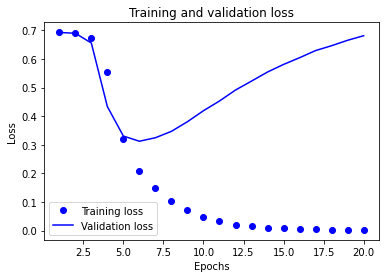

In [44]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

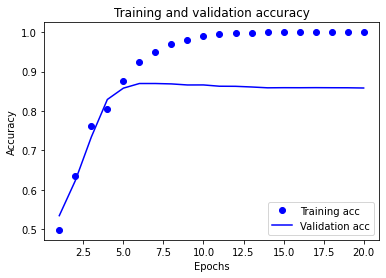

In [45]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [46]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [47]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [48]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.02410159,  0.01935444,  0.03691344,  0.00057826, -0.01686076,
        0.03808233, -0.0030182 ,  0.04028698,  0.04731144,  0.01686353,
        0.09436119,  0.00116338, -0.04299448, -0.0303202 , -0.01227619,
        0.01073069], dtype=float32)

In [49]:
word_vectors.similar_by_word("love")

[('neat', 0.8842307329177856),
 ('dandy', 0.8464125394821167),
 ('christensen', 0.8398094773292542),
 ('intrigue', 0.8375747799873352),
 ('houses', 0.8317248821258545),
 ('refuses', 0.8316463232040405),
 ('brilliantly', 0.8290098309516907),
 ('great', 0.8288865685462952),
 ('spotted', 0.8268099427223206),
 ('live', 0.8208229541778564)]

In [51]:
from gensim.models import KeyedVectors

word2vec_path = './data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [52]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [53]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [71]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 580, 300)          3000000   
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 300)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [72]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 2s 38ms/step - loss: 0.6985 - accuracy: 0.5233 - val_loss: 0.6872 - val_accuracy: 0.5447
Epoch 2/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6813 - accuracy: 0.5828 - val_loss: 0.6816 - val_accuracy: 0.5778
Epoch 3/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6739 - accuracy: 0.6100 - val_loss: 0.6781 - val_accuracy: 0.5904
Epoch 4/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6670 - accuracy: 0.6229 - val_loss: 0.6725 - val_accuracy: 0.5834
Epoch 5/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6629 - accuracy: 0.6071 - val_loss: 0.6720 - val_accuracy: 0.5912
Epoch 6/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6529 - accuracy: 0.6392 - val_loss: 0.6618 - val_accuracy: 0.6132
Epoch 7/20
30/30 [==============================] - 1s 32ms/step - loss: 0.6442 - accuracy: 0.6503 - val_loss: 0.6566 - val_accuracy: 0.6144
Epoch 8/20
30

In [73]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 1s - loss: 0.6474 - accuracy: 0.6430
[0.6474026441574097, 0.6429600119590759]


In [74]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


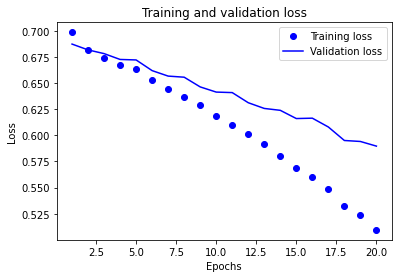

In [75]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

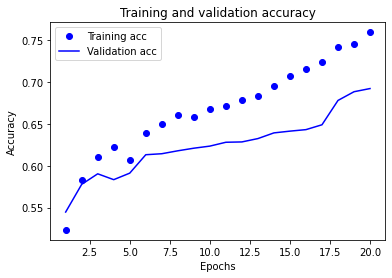

In [76]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()